# Decoupling “Hip Hop” and “Rap” – A Textual Analysis of Rap Lyrics from 1980s to 2010s
## Bryan Kim

13 August 2022

Introduction to Computational Literary Analysis

Department of Digital Humanities, University of California, Berkeley

Instructor: Jonathan Reeve

## Introduction
Contemporary music often faces criticism fueled by rosy nostalgia, that music today just “ain’t what it used to be.” This attitude can be directed towards any genre of music, but a particular genre of interest is hip-hop. The spoken-word delivery and poetry-like structure of hip-hop music means artists can deliver more words compared to other genres, thus creating more dense lyrics that lend itself to textual analysis.

The pessimistic perspective that “Hip Hop Is Dead” permeates through the outlooks of both rappers and rap fans alike in the hip-hop community; in fact, the aforementioned phrase is literally the title of rapper Nas’ 2006 album. Yet, hip-hop is anything but dead in the 21st century – rap has firmly embedded itself in mainstream American music culture at large. Nevertheless, critics will maintain their positions that hip-hop lyrics over time have lost their touch with clever rhymes, expansive vocabulary, and substantial storytelling: traits that had defined and emblazoned hip-hop in its heyday of 1980s and 1990s. 

Yet, Zack Linly, poet and columnist writer at *The Root*, offers a perspective that goes against the hellbent nostalgia, in that “if you’re still saying, 'That ain’t real hip-hop!' you need to return your whole narrative to 2004 and go find yourself a cave to go cry in. It’s all hip-hop.” Linly implies that rap has continually maintained some quality(s) that define hip-hop, and that maintenance validates modern rappers to the level of their emcee precedessors. From Grandmaster Flash to Lil Pump, they are all cut from the same cloth. Despite Linly's defense, it is worth looking into the validity of his claim of connectivity across the holistic genre, that "it's all hip-hop."

What does it mean to be hip-hop? Inquiring further, hip-hop and rap are terms that are often conflated with one another, so what is the difference? In his 2003 song “9 Elements,” Rapper KRS-One asserts that “rap is something you do; hip hop is something you live.” KRS-One posits “rap” as the mere action or skill of rhythmically reciting lyrics. “Hip-hop,” however, relates to a lifestyle, a cultural identity that "rap" alone does not encompass. Academic perspectives from professors Marcyliena Morgan and Dionne Bennett also view rapping as a subset of hip-hop and offer a more didactic criteria of hip-hop’s “core elements — rapping, deejaying, breaking (dance), and graffiti art … hip-hop is distinguished from the term rap in that it does not focus solely on spoken lyrics.”

If hip-hop is defined to be associated with activities such as rapping, DJ-ing, dancing, graffiti, etc., then does Linly’s defense of modern rap in that “it’s all hip-hop" hold true? To answer, computational literary analysis techniques were employed on a corpus of rap lyrics over time.

## Loading Libraries, Packages, and Data Files

In [1]:
import nltk
import re
import matplotlib.pyplot as plt
import pandas as pd
import decadeDicts ## load a separate decadeDicts.py file with all the lyrics pre-scraped from Genius and organized into dictionaries.
import pronouncing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk.corpus import stopwords

For each of four decades, one hundred rap songs were selected from online "Top 100" ranking lists ([1980s](https://hiphopgoldenage.com/list/the-best-hip-hop-songs-1980s/), [1990s](https://hiphopgoldenage.com/list/top-100-hip-hop-songs-of-the-1990s/), [2000s](https://www.liveabout.com/best-rap-songs-of-the-2000s-2857792), [2010s](https://rap2010s.theringer.com/)).

The raw lyrics were pulled from the Genius website via the Genius API, then stored into dictionaries for each of the four decades. The dictionaries were assembled in a separate `decadeDicts.py` file, which we import from.

In [2]:
decade80sDict = decadeDicts.decade80sOriginal.copy()
decade90sDict = decadeDicts.decade90sOriginal.copy()
decade00sDict = decadeDicts.decade00sOriginal.copy()
decade10sDict = decadeDicts.decade10sOriginal.copy()

They were then pre-processed below. Beyond usual steps such as lowercasing and removing punctuation, certain artifacts of the Genius formats had to be removed, such as headers and part tags (e.g. "[Chorus]", "[Verse 1]"). In order to standardize word frequencies, duplicate words were also removed in order to avoid over-mentioning of certain words such as in choruses. 

In [3]:
## A bunch of cleaning/processing functions

# remove "Embed" phrase Genius website artifact 
def removeEmbed(lyrics):
    lyrics = lyrics.replace("Embed", "")
    lyrics = removeEndingDigits(lyrics)
    return lyrics

# remove header
def removeHeader(lyrics):
    return re.sub(r"^.+?lyrics", "", lyrics)

# used in conjunction w/ removeEmbed() to remove artifacts like "Embed7" or "Embed3"
def removeEndingDigits(embedlessLyrics):
    while embedlessLyrics[-1].isdigit():
        embedlessLyrics = embedlessLyrics[:-1]
    return embedlessLyrics

# remove part tags like "[Chorus]" or "[Verse 1]"
def removePartTags(lyrics):
    return re.sub("[\[].*?[\]]", "", lyrics)

# lowercase function
def lower(lyrics):
    return lyrics.lower()

# standardize some common slang in lyrics
def fixPhrases(lyrics):
    lyrics = lyrics.replace("wan'na", "wanna")
    lyrics = lyrics.replace("gon'na", "gonna")
    lyrics = lyrics.replace("wan na", "wanna")
    lyrics = lyrics.replace("gon na", "gonna")
    lyrics = lyrics.replace("got'ta", "gotta")
    lyrics = lyrics.replace("ai n't", "ain't")
    return lyrics

# replace certain characters with either spaces or remove them entirely
def cleanChars(lyrics):
    chars1 = [".", ",","?","!","(",")"]
    chars2 = [ "–", "—","-","\n"]
    for char in chars1:
        lyrics = lyrics.replace(char, '')
    for char in chars2:
        lyrics = lyrics.replace(char, ' ')
    return lyrics

def processLyrics(lyrics):
    headerLessLyrics = removeHeader(lyrics)
    charlessLyrics = cleanChars(headerLessLyrics)
    embedlessLyrics = removeEmbed(charlessLyrics)
    taglessLyrics = removePartTags(embedlessLyrics)
    loweredLyrics = lower(taglessLyrics)
    fixedLyrics = fixPhrases(loweredLyrics)
    return fixedLyrics

## for some reason, the processing function works properly only if applied twice
for song in decade80sDict.keys():
    decade80sDict[song] = processLyrics(processLyrics(decade80sDict[song]))
for song in decade90sDict.keys():
    decade90sDict[song] = processLyrics(processLyrics(decade90sDict[song]))
for song in decade00sDict.keys():
    decade00sDict[song] = processLyrics(processLyrics(decade00sDict[song]))
for song in decade10sDict.keys():
    decade10sDict[song] = processLyrics(processLyrics(decade10sDict[song]))

The processed lyrics can be previewed by looking at the first song in each decade's dictionary:

In [4]:
decadeDictsList = [decade80sDict,decade90sDict,decade00sDict,decade10sDict]
for decadeDict in decadeDictsList:
    firstSongTitle = list(decadeDict.keys())[0] 
    first200Lyrics = decadeDict[firstSongTitle][:200]
    print(firstSongTitle + ": " + first200Lyrics + "\n")

The Message by Grandmaster Flash & The Furious Five:  it's like a jungle sometimes it makes me wonder how i keep from going under it's like a jungle sometimes it makes me wonder how i keep from going under   broken glass everywhere people pissing on the

They Reminisce Over You (T.R.O.Y.) by Pete Rock & CL Smooth:   i reminisce i reminisce i reminisce i reminisce i reminisce i reminisce i reminisce i reminisce uh i reminisce i reminisce yeah i reminisce i reminisce i reminisce i reminisce i reminisce i reminisc

Swagga Like Us by T.I.:  no one on the corner has swagger like us swagger like us swagger swagger like us no one on the corner has swagger like us swagger like us swagger swagger like us no one on the corner has swagger like

BIG TYMIN’ by NEF THE PHARAOH:  we up to 40 on the oppers and we droppin' niggas ya'll squad wannabes ya'll really not them niggas ya'll not them niggas man ya'll fakers   ooh i'm ballin' like baby these bitches they wanna have my 



## Separation of Decades by Lyrical Vocabulary

To get a sense of how the eras of rap differ from one another, a PCA map was generated from the 400 most common words in each decade's holistic lyrics.

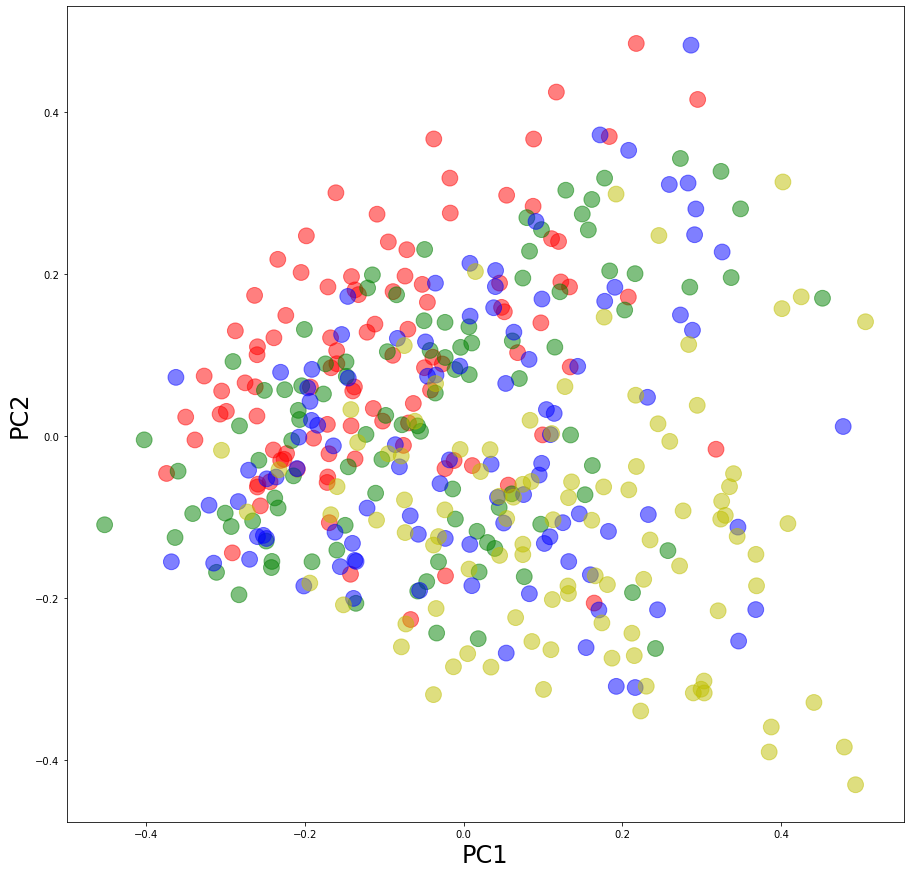

In [5]:
def getSongTitles(decadeDict):
    return list(decadeDict.keys())
def getSongLyrics(decadeDict):
    return list(decadeDict.values())

def getTitlesAndLyrics(decadeDict):
    return getSongTitles(decadeDict), getSongLyrics(decadeDict)

decade80sSongTitles, decade80sSongLyrics = getTitlesAndLyrics(decade80sDict)
decade90sSongTitles, decade90sSongLyrics = getTitlesAndLyrics(decade90sDict)
decade00sSongTitles, decade00sSongLyrics = getTitlesAndLyrics(decade00sDict)
decade10sSongTitles, decade10sSongLyrics = getTitlesAndLyrics(decade10sDict)

allTitles = decade80sSongTitles+decade90sSongTitles+decade00sSongTitles+decade10sSongTitles
allLyrics = decade80sSongLyrics+decade90sSongLyrics+decade00sSongLyrics+decade10sSongLyrics

numFreqWords = 400
tfidfVectorizer = TfidfVectorizer(max_features=numFreqWords,use_idf=False)

textMatrix = tfidfVectorizer.fit_transform(allLyrics)
denseTextMatrix = textMatrix.todense()
pca = PCA(n_components=2)
textPoints = pca.fit_transform(denseTextMatrix)

text_df = pd.DataFrame(textPoints,index=allTitles,columns=['C1','C2'])
ax = text_df.plot(kind='scatter',x='C1',y='C2',c=list(["r"]*100+["g"]*100+["b"]*100+["y"]*100),alpha=0.5,figsize=(15,15),s=250);
plt.xlabel('PC1',fontsize=24)
plt.ylabel('PC2',fontsize=24);

**Figure 1**: Principal components constructed from the 800 most frequent words for lyrics of each decade: the 1980s (red), 1990s (green), 2000s (blue), and 2010s (yellow).

From visual observation of the colors in Figure 1, the points' separations roughly follows a chronological gradient, in that red 1980s songs make up one extreme in the top left and the yellow 2010s songs the other in the bottom right. The green 1990s songs and blue 2000s are interspersed roughly in the middle regime. The relatively visible separation, especially between red and yellow points, speaks to the differences in vocabulary in each decade's songs' lyrics. The lack of well-defined boundaries across each decade underlines that songs over time bleed into one another and take influence from each other. A song from the 1980s could possibly read like one from 2010s (and vice versa). 

Why are the 1980s and 2010s so different in lyrical vocabulary? This difference can be analyzed more closely by looking into what artists are rapping about in their lyrics. Specifically, Latent Dirichlet Allocation (LDA) can be leverged to model topics that each decade's rappers tend to talk about.

## LDA Modeling to Visualize Topical Changes in Rap

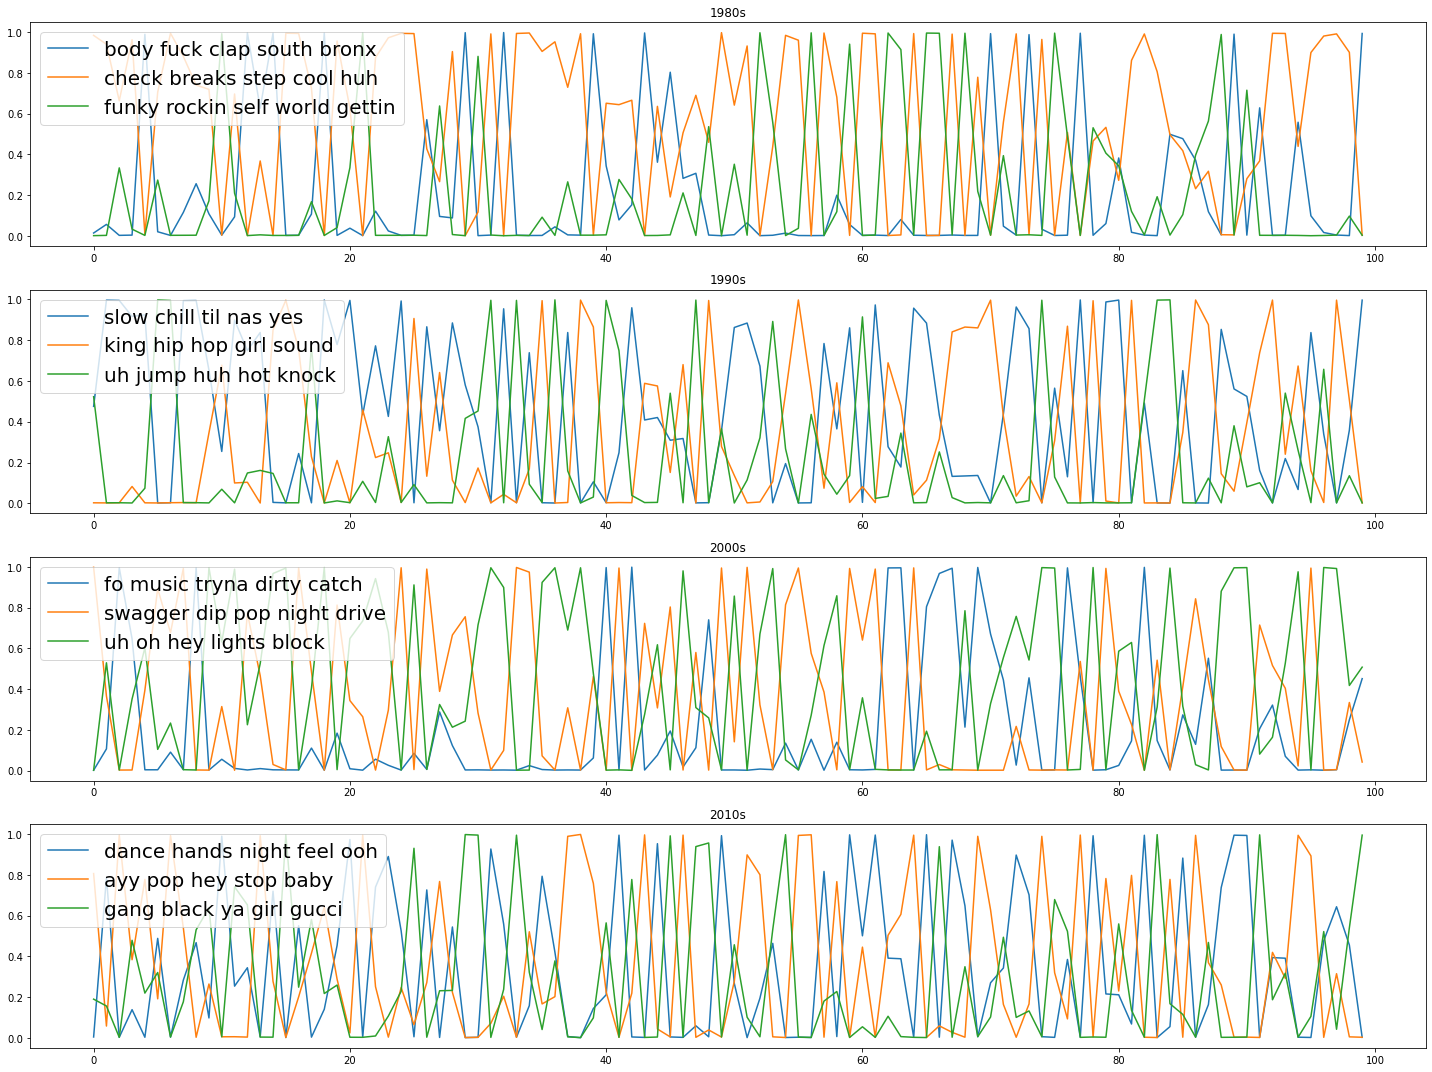

In [6]:
def getWords(topicName):
    return ' '.join(list(topicWordMatrix.loc[topicName].sort_values(ascending=False).head(5).index))

countVectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=0.3)
numComponents=3
lda = LatentDirichletAllocation(n_components=numComponents)

decadeLyricsList = [decade80sSongLyrics,decade90sSongLyrics,decade00sSongLyrics,decade10sSongLyrics]

fig, axs = plt.subplots(4)

for i, decadeLyrics in enumerate(decadeLyricsList):
    wordCounts = countVectorizer.fit_transform(decadeLyrics)
    wordLabels = countVectorizer.get_feature_names()
    ldaOut = lda.fit_transform(wordCounts)
    topicWordMatrix = pd.DataFrame(lda.components_,index=['Topic ' + str(x) for x in range(numComponents)],columns=wordLabels)
    topicLabelsWords = [getWords(topic) for topic in ['Topic ' + str(x) for x in range(numComponents)]]
    pd.DataFrame(ldaOut,columns=topicLabelsWords).plot(figsize=(20,15),ax=axs[i]);
    axs[i].legend(prop={'size': 20},loc="upper left");
    axs[i].set_title(str(1980+i*10) + "s")
plt.tight_layout();

**Figure 2**: LDA modeling to discern three potential topical categories (w/ five keywords) for each decade.

The topics discerned also show a change over time across the decades that is telltale of the genre's lyrical evolution. The topics in the 1980s and 1990s embody the spirit of hip-hop's core elements, with keywords like "funky", "rockin", "hip hop", and "south bronx", which is likely in reference to the West versus East coasts rivalry that permeated in the 1980s and 1990s (with New York City as the Mecca of East Coast hip-hop). However, the 2000s and 2010s display topic keywords like "music", "night", "lights", "dance", etc. This topical change can be correlated with the genre's incorporation over time of musical and cultural elements of pop music, as observed by Jon Caramanica of *The New York Times*. While it is tempting to consider mentions of the word "pop" in the 2000s/2010s' topics as emblematic of rap's assimilation into pop music, in reality the word "pop" is primarily used as a verb ("pop the trunk") or onomatopoeia ("pop pop") in these lyrics.  

Caramanica's observation that newer songs have begun favoring the rapping-singing formula derived from hybridizing pop and rap can relate to a supposed displacement of more traditional hip-hop elements, or even lessened self-identification with the term "hip-hop" itself. These suppositions can be assessed by analyzing the proportions of certain keywords' mentions in each decade's lyrics.

## Assessing Referentiality of Hip-Hop Traits over Time

In [7]:
decadeTextTokens = []
for decadeDict in decadeDictsList:
    allLyricsString = ' '.join(list(decadeDict.values()))
    decadeTokens = nltk.word_tokenize(allLyricsString)
    decadeTokensAlpha = [token for token in decadeTokens if token.isalpha()]
    decadeTextTokens.append(decadeTokensAlpha)

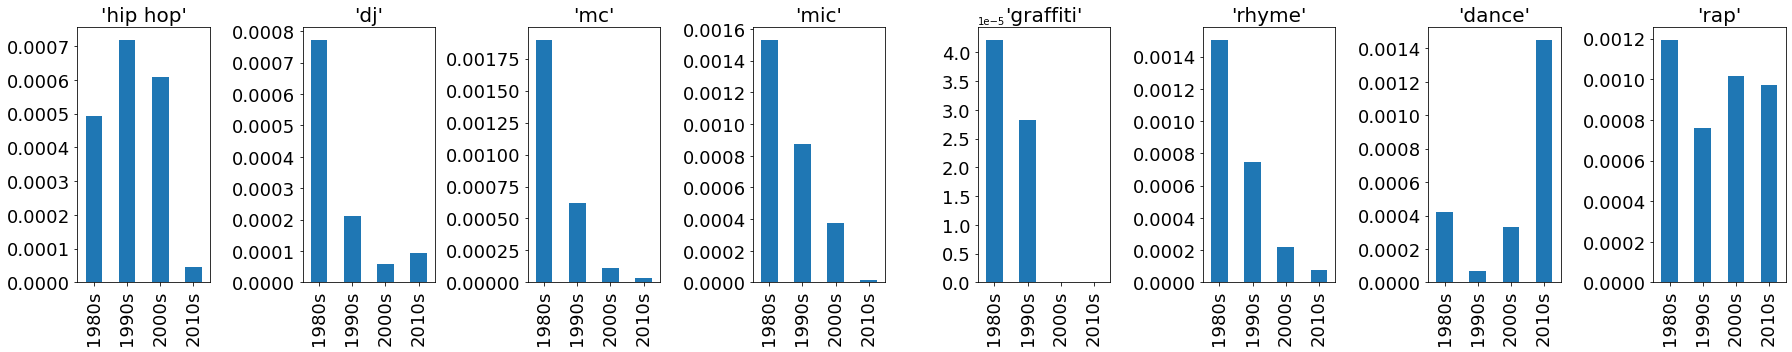

In [8]:
def keywordProportion(tokens,keywords):
    patterns=[]
    numKeywords = len(keywords)
    for i, word in enumerate(tokens):
        if i == len(tokens) - numKeywords:
            break
        if numKeywords == 1: ## for single words like "dj, mc, etc."
            if word == keywords[0]:
                patterns.append([word])
        if numKeywords == 2: ## for double words like "hip hop"
            nextWord = tokens[i+1]
            if word == keywords[0]:
                if nextWord == keywords[1]:
                    patterns.append([word,nextWord])
    return len(patterns) / len(tokens)

traditionalKeywords = [["hip","hop"],["dj"],["mc"],["mic"],["graffiti"],["rhyme"],["dance"],["rap"]]

fig, axs = plt.subplots(1,len(traditionalKeywords))

for i, keywords in enumerate(traditionalKeywords):
    proportions = {str(1980+i*10) + "s": keywordProportion(decadeTextTokens[i],keywords) for i in range(len(decadeTextTokens))} 
    pd.Series(proportions).plot(kind='bar',ax=axs[i],figsize=(25,5),fontsize=18)
    axs[i].set_title("'" + (" ".join(keywords))+"'",fontsize=20);
plt.tight_layout();

**Figure 3**: Proportions of mentions of keywords related to traditional perceptions of hip-hop across the four decades.

Based on Morgan and Bennett's definition of hip-hop as relational to activites like DJ-ing, dance, and graffiti, such keywords were counted and proportionalized across each decade. Other relevant hip-hop traits such as MC-ing and rhyming were also counted.

Keywords like "dj", "mc", "graffiti" have shown less and less mentions over the decades, and this decrease can be attributed to how such activities have become less visible in cultural relevance over time. What is particularly striking, however, is that mentions of "hip hop" have also decreased, in an almost meteoric fashion between 2000s and 2010s. Meanwhile, "dance" has increased drastically in mentions in 2010s, perhaps due to the influences of pop music and the eventual shift from pure rap to rapping-singing such that "dance" is referenced more frequently. However, there is a non-trivial amount of mentions of "dance" in the 1980s too, likely due to early hip-hop's influences from dance related genres such as disco, funk, and soul, as noted by artist Questlove in his 2014 opinion piece on *Vulture*. "Rap", albeit reaching maximum proportion of mentions in the 1980s, has shown a more consistent trend across time well into the 21st century. 

This difference in self-referentiality speaks volumes to how artists have shifted in alignment from "hip-hop" to "rap" as self-identification. Hip-hop contains more traditional, old-school connotations that have become anachronistic, which reflects in the decrease in mentions of not only "hip hop", but activities like "dj" and "graffiti." However, despite being simply put as merely a single element of hip-hop, "rap" is the core quality that has stood the test of time. Although rapping can thus be identified as the singular quality that Linly attributes to all the songs being "hip-hop," it is incongruent to equate the pop-influenced rappers of today to the MC/DJ-ing hip-hop artists of yesteryears. "Rap" has become larger than just "something you do" as KRS One put it. It is an identity, a culture shaped over time that has become separable from hip-hop itself. Indeed, rap too has become "something you live," and looking further into a sample of actual lyrics can underscore this transformation. 

## Close-Reading Lyrics for Alignment between Hip-Hop and Rap

A song from each decade can be selected for lyrical analysis, since the nuances of the change in alignment between "hip hop" and "rap" can be more deeply captured by literally reading the lyrics.
> I hold the microphone like a grudge 

> B'll hold the record so the needle don't budge 

> I hold a conversation 'cause what I invent 

> I nominated my DJ for president 

> When I emcee, I'll keep a freestyle going steadily 


The 1987 record “I Ain’t No Joke” by Eric B. & Rakim above contains several vestiges of old-school, traditional hip-hop – "microphone", "DJ", "emcee", "freestyle." 

> We're from the family tree of old school hip-hop

> Kick off your shoes and relax your socks

> The rhymes will spread just like a pox

The Beastie Boys' 1998 hit "Intergalactic" runs in the same vein as traditional hip-hop of the 1980s, as it even couples "hip-hop" with "old school."


> And I don't rap fast, I rap slow 

> 'Cause I mean every letter in the words

> In the sentence of my quotes

In Lil Wayne's "Dr. Carter" in 2006, "rap" is still relegated to a mere action, just "something you do," but it is a more prominent quality for newer artists than traditional hip-hop's rhyming and emcee-ing.

> It's feelin' like rap changed

> It was a time it was rugged

In Drake's verse in Rick Ross' 2012 song "Stay Schemin'", "rap" literally is treated as a noun, no longer an action. The word is also used by Drake to describe the changes in the music genre at large. An interesting experiment to consider is to replace the "rap" with the word(s) "hip-hop" – both words operate as reference to the bigger culture, which signifies how the word "rap" has evolved from a mere component of the hip-hop skillset to a fully-fledged descriptor of the entire music genre. Modern rap artists have differentiated themselves from past hip-hop artists by transforming the word "rap" into "something [they] live," a lifestyle distinct from that of hip-hop.

## Conclusion

To revisit if Linly’s defense of modern rap in that “it’s all hip-hop” holds true – no. It is anachronistic to evaluate modern rap with respect to hip-hop, as modern rappers have redefined themselves away from traditional hip-hop traits with elements of pop music. Instead, it is more fitting to say that "it’s all rap" and recognize that rap has evolved from not just “something you do,” but a genuine musical identity in and of itself that modern artists more closely align with than hip-hop culture. While Morgan and Bennett's criteria of hip-hop might have been appropriate for 20th century rappers, the anachronisms of graffiti and MC-ing have made it more difficult for modern rappers to relate to hip-hop traditions simply because the culture has vastly changed over the years. For older rappers like KRS One, "rap" may seem like a subset of hip-hop, but "rap" today ought to be recognized as its own cultural object that separates itself from hip-hop predecessors. A potential follow-up analysis for this project could look into how the word "rap" is used as a part of speech over time. Given that older connotations of "rap" are more skill-oriented (i.e. verb) and newer meanings of "rap" refer to the genre/culture at large (i.e. noun) as seen in the close-reading section, it could be predicted that over time there is a decrease in "rap" as a verb and increase as a noun.

## Works Cited

Beastie Boys.  Lyrics to “Intergalactic.” *Genius*, 2022.

Caramanica, Jon. "How a New Kind of Pop Star Stormed 2018." *The New York Times*, 20 Dec, 2018.

Eric B. & Rakim.  Lyrics to “I Ain't No Joke.” *Genius*, 2022.

KRS One.  Lyrics to “9 Elements.” *Genius*, 2022.

Lil Wayne.  Lyrics to “Dr. Carter.” *Genius*, 2022.

Linly, Zack. "Is Today’s Hip-Hop Trash or Are We Just Getting Old? Spoiler Alert: The Answer Is ‘Yes.’" *The Root*, 1 Feb, 2018.

Morgan, Marcyliena and Bennett, Dionne. "Hip-Hop & the Global Imprint of a Black Cultural Form." *Daedalus,* vol. 140, no. 2, Spring 2011, pp. 176-196, *The MIT Press*.

Rick Ross, Drake, and French Montana. Lyrics to “Stay Schemin'.” *Genius*, 2022.

Questlove. "Disco and the Return of the Repressed — How Hip-Hop Failed Black America Part IV." *Vulture*, 13 May, 2014.